# I. Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Đường dẫn đến file Excel
file_path = r"E:\SkyRevenue Insights\0. Data\df_cleaned.xlsx"

# Kiểm tra file có tồn tại không
import os
if os.path.exists(file_path):
    print("File tồn tại!")
else:
    print("File không tồn tại, kiểm tra lại đường dẫn!")
    raise FileNotFoundError("File không tồn tại!")

# Đọc sheet "Data"
df_org = pd.read_excel(file_path)
df = df_org.copy()
# Hiển thị vài dòng đầu của DataFrame để kiểm tra
df.head()

File tồn tại!


,order_id,ticket_id,passenger_id,passenger_gender,passenger_age,ticket_source_name,ticket_status,created_date,departure_date,departure_time,...,seat_class,ticket_price,baggage,insurance_fee,discount_amount,seat_category,age_group,lead_time_days,from,to
0,20205,31268,Xs1fLinPQun+Oy/mD0FlfXMyJD38YlXJfXNbz+qO+5U=,Female,40,IOS,Paid,2023-03-01,2023-03-14,17:55:00,...,I1_ECO,867760,0,0,45000,Economy,Adults (35-59),13,Đắk Lắk,Hồ Chí Minh
1,20190,31242,m/auVlEoaGSe2MqR/Lq4CFXJnI8zauNyF/KiFmMgXHs=,Female,40,GYL,Paid,2023-03-01,2023-03-02,09:30:00,...,Z1_ECO,974280,0,0,45000,Economy,Adults (35-59),1,Đắk Lắk,Hồ Chí Minh
2,20245,31337,6HvtV2vTqUfNBJ53C4TzvJnb0s74KgcRNuUVS+8jRvU=,Female,48,IOS,Paid,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1423080,0,0,16000,Economy,Adults (35-59),40,Thừa Thiên Huế,Hồ Chí Minh
3,20259,31360,WiK2P31WEd4mckRNVWz0C2aKKRgSrauAG8NdfTLnKjE=,Male,29,Android,New,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1067310,0,0,45000,Economy,Young Adults (18-34),40,Thừa Thiên Huế,Hồ Chí Minh
4,20255,31355,6HvtV2vTqUfNBJ53C4TzvJnb0s74KgcRNuUVS+8jRvU=,Female,42,IOS,Paid,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1067310,0,0,24000,Economy,Adults (35-59),40,Thừa Thiên Huế,Hồ Chí Minh


# II. Analysis

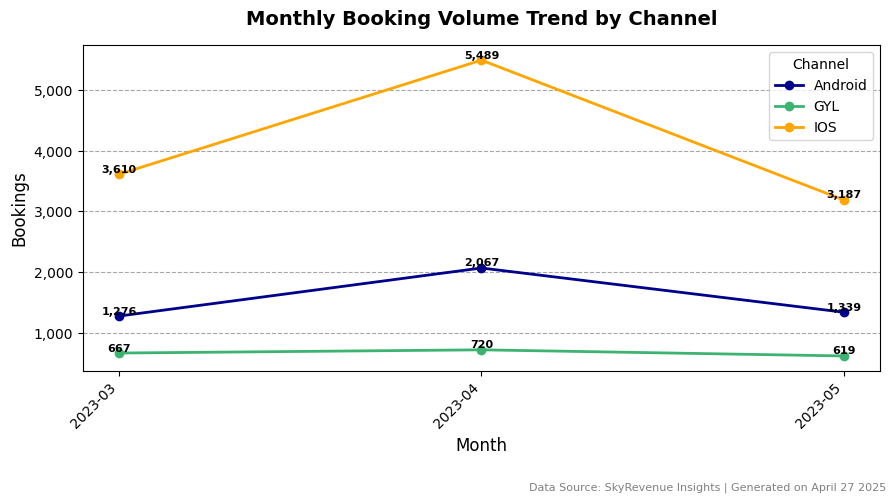

In [4]:
# ------------------------------------------------------------
# CHART – Monthly Booking Volume Trend (line chart từng kênh)
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣  Chuẩn bị dữ liệu
df['order_month'] = pd.to_datetime(df['created_date']).dt.to_period('M').dt.to_timestamp()

monthly_bookings = (
    df.groupby(['order_month', 'ticket_source_name'])['ticket_id']
      .count()
      .reset_index()
      .rename(columns={'ticket_id': 'Bookings'})
)

pivot_mb = (
    monthly_bookings
      .pivot(index='order_month', columns='ticket_source_name', values='Bookings')
      .fillna(0).astype(int)
      .sort_index()
)

# 2️⃣  Vẽ line chart
fig, ax = plt.subplots(figsize=(9, 5))

# Màu cố định để nhất quán (có thể đổi nếu kênh nhiều hơn)
color_map = ['darkblue', 'mediumseagreen', 'orange', 'purple', 'red', 'brown']

for i, ch in enumerate(pivot_mb.columns):
    ax.plot(
        pivot_mb.index.strftime('%Y-%m'),
        pivot_mb[ch],
        marker='o',
        linewidth=2,
        color=color_map[i % len(color_map)],
        label=ch
    )
    # Annotate từng điểm
    for x, y in zip(pivot_mb.index.strftime('%Y-%m'), pivot_mb[ch]):
        ax.text(x, y, f'{y:,}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 3️⃣  Decor / định dạng
ax.set_title("Monthly Booking Volume Trend by Channel", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Bookings", fontsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.7, color='grey')
plt.xticks(rotation=45, ha='right')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.legend(title="Channel")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.figtext(
    0.99, 0.01,
    'Data Source: SkyRevenue Insights | Generated on April 27 2025',
    ha='right', fontsize=8, color='gray'
)
plt.show()


In [5]:
# ---------------------------------------------------------
# ❷  CHECK: ARE APRIL BOOKINGS FOR HOLIDAY 30-4 / 1-5 ?
# ---------------------------------------------------------
df["order_month"] = pd.to_datetime(df["created_date"]).dt.to_period("M").dt.to_timestamp()
df["departure_date"] = pd.to_datetime(df["departure_date"])

# bookings created in April
april_mask = df["order_month"].dt.month == 4
april = df[april_mask]

# define holiday window
holiday_start = pd.Timestamp("2023-04-28")
holiday_end = pd.Timestamp("2023-05-03")

holiday_mask = (april["departure_date"] >= holiday_start) & (april["departure_date"] <= holiday_end)
april_holiday = april[holiday_mask]

summary = {
    "Metric": ["Total April Bookings",
               "Bookings Depart 28/4–3/5",
               "Percentage"],
    "Value": [len(april),
              len(april_holiday),
              f"{len(april_holiday)/len(april)*100:.1f}%"]
}
summary_df = pd.DataFrame(summary)
print(summary_df)

# percentage by channel
channel_pct = (
    april_holiday.groupby("ticket_source_name")["ticket_id"].count() /
    april.groupby("ticket_source_name")["ticket_id"].count() * 100
).round(1).reset_index().rename(columns={"ticket_id": "Holiday %"})
print(channel_pct)


                     Metric  Value
0      Total April Bookings   8276
1  Bookings Depart 28/4–3/5   1623
2                Percentage  19.6%
  ticket_source_name  Holiday %
0            Android       19.2
1                GYL       12.4
2                IOS       20.7


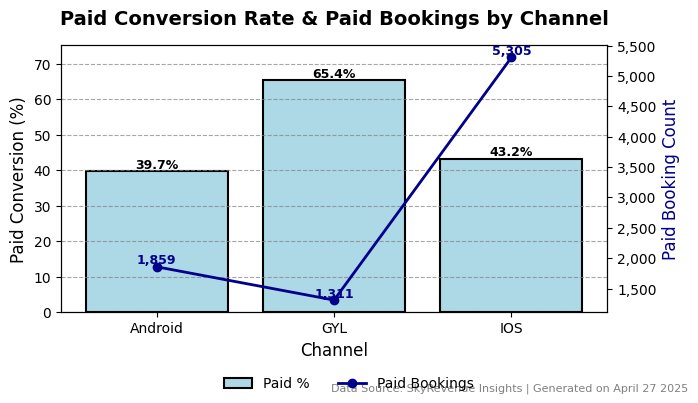

In [6]:
# ------------------------------------------------------------
# CHART 2 – Paid Conversion Rate (Bar) & Paid Bookings (Line)
# ------------------------------------------------------------

# 1️⃣   Chuẩn bị dữ liệu
funnel = (
    df.groupby(['ticket_source_name', 'ticket_status'])['ticket_id']
      .count()
      .unstack(fill_value=0)
)

funnel['Paid_%'] = (funnel.get('Paid', 0) / funnel.sum(axis=1) * 100).round(1)
funnel['Paid_Count'] = funnel.get('Paid', 0)

# 2️⃣   Vẽ chart
fig, ax = plt.subplots(figsize=(7, 4))
x = funnel.index

# Bar: Paid %
bars = ax.bar(
    x, funnel['Paid_%'],
    color='lightblue', edgecolor='black', linewidth=1.5,
    label='Paid %'
)
for bar in bars:
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
            f"{bar.get_height():.1f}%", ha='center', va='bottom',
            fontsize=9, fontweight='bold')

ax.set_ylabel('Paid Conversion (%)', fontsize=12)
ax.set_ylim(0, max(funnel['Paid_%'])*1.15)

# Line: Paid Count
ax2 = ax.twinx()
line = ax2.plot(x, funnel['Paid_Count'],
                color='darkblue', marker='o', linewidth=2,
                label='Paid Bookings')[0]
for i, y in enumerate(funnel['Paid_Count']):
    ax2.text(i, y, f'{y:,}', ha='center', va='bottom',
             fontsize=9, fontweight='bold', color='darkblue')
ax2.set_ylabel('Paid Booking Count', fontsize=12, color='darkblue')
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.grid(False)

# Decor
ax.set_title('Paid Conversion Rate & Paid Bookings by Channel',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Channel', fontsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.7, color='grey')
plt.xticks(rotation=45, ha='right')

handles, labels = [], []
for a in (ax, ax2): h,l = a.get_legend_handles_labels(); handles+=h; labels+=l
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.figtext(0.99, 0.01,
            'Data Source: SkyRevenue Insights | Generated on April 27 2025',
            ha='right', fontsize=8, color='gray')
plt.show()


=== Lead-Time (ALL bookings) ===
count    18974.000000
mean        13.220934
std         17.931098
min          0.000000
25%          2.000000
50%          7.000000
75%         17.000000
90%         33.000000
95%         48.000000
99%         86.000000
max        271.000000


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_33352\881619492.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


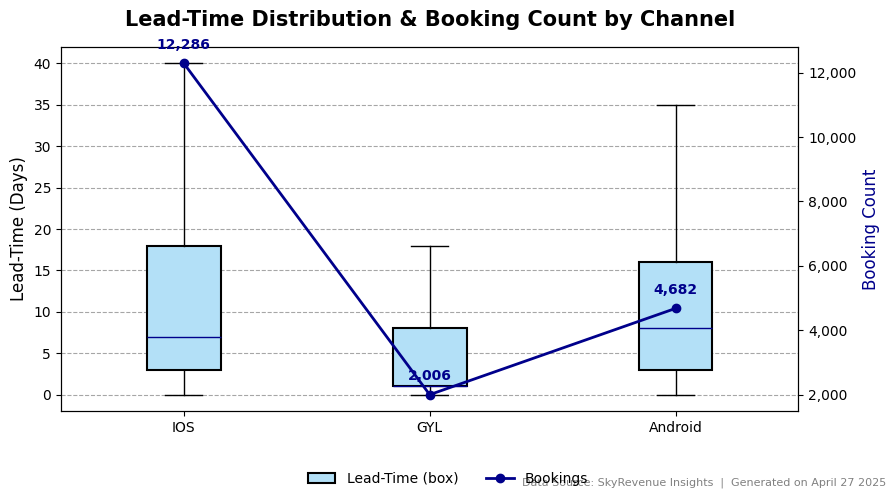

In [7]:
# ------------------------------------------------------------
# CHART – Lead-Time Distribution (Box) & Booking Count (Line)
# ------------------------------------------------------------
# ---------- 2. Descriptive statistics ----------
stats_all = df['lead_time_days'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
stats_clean = df.loc[df['lead_time_days'] <= 180, 'lead_time_days'] \
                .describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("=== Lead-Time (ALL bookings) ===")
print(stats_all.to_string())
# ---------- 3. Vẽ boxplot & line chart ----------

# 1️⃣  Chuẩn bị dữ liệu
channels = df['ticket_source_name'].unique().tolist()
lead_by_channel = [df.loc[df['ticket_source_name'] == ch, 'lead_time_days'] for ch in channels]

bookings = (
    df.groupby('ticket_source_name')['ticket_id']
      .count()
      .reindex(channels)        # đảm bảo thứ tự trùng boxplot
)

# 2️⃣  Vẽ plot
fig, ax = plt.subplots(figsize=(9, 5))

# --- BOX: Lead-Time distribution
box = ax.boxplot(
    lead_by_channel,
    labels=channels,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='#b3e0f7', edgecolor='black', linewidth=1.5),
    medianprops=dict(color='darkblue')
)

ax.set_ylabel('Lead-Time (Days)', fontsize=12)

# --- LINE: Booking Count
ax2 = ax.twinx()
line = ax2.plot(
    np.arange(1, len(channels)+1), bookings,
    color='darkblue', marker='o', linewidth=2,
    label='Bookings'
)[0]

# Annotate Booking Count
y_off = 0.03 * bookings.max()
for i, y in enumerate(bookings, start=1):
    ax2.text(i, y + y_off,
             f"{y:,}", ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='darkblue')

ax2.set_ylabel('Booking Count', fontsize=12, color='darkblue')
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda v, _: f'{int(v):,}'))
ax2.grid(False)

# Decor
ax.set_title('Lead-Time Distribution & Booking Count by Channel',
             fontsize=15, fontweight='bold', pad=15)
ax.grid(True, axis='y', linestyle='--', alpha=0.7, color='grey')

# Legend gộp
handles, labels = [], []
h1, l1 = [box["boxes"][0]], ['Lead-Time (box)']
h2, l2 = ax2.get_legend_handles_labels()
handles += h1 + h2; labels += l1 + l2
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0.09, 1, 1])
plt.figtext(0.99, 0.02,
            'Data Source: SkyRevenue Insights  |  Generated on April 27 2025',
            ha='right', fontsize=8, color='gray')
plt.show()


                    Discount_Uptake  Avg_Discount_Rate
ticket_source_name                                    
Android                       66.55               2.28
GYL                           62.86               2.24
IOS                           65.89               2.37


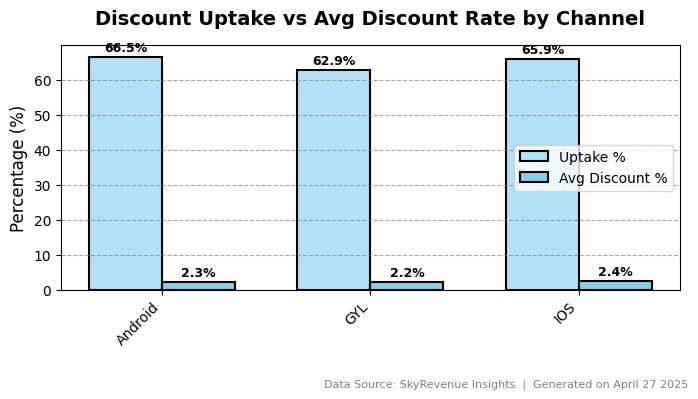

In [8]:
# ---------------------------------------------------------
# ❸  DISCOUNT UPTAKE vs AVG DISCOUNT RATE — FIXED DESIGN
# ---------------------------------------------------------
df["discount_flag"] = df["discount_amount"] > 0

disc_metrics = (
    df.groupby("ticket_source_name")
      .agg(
          Discount_Uptake=("discount_flag", lambda x: x.mean()*100),
          Avg_Discount_Rate=("discount_amount",
                             lambda x: x.sum()/df.loc[x.index, "ticket_price"].sum()*100)
      )
      .round(2)
)
print(disc_metrics)

# ----- PLOT -----
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(disc_metrics))
bar_width = 0.35

bars1 = ax.bar(
    x - bar_width/2, disc_metrics["Discount_Uptake"],
    width=bar_width, color="#b3e0f7", edgecolor="black",
    linewidth=1.5, label="Uptake %"
)
bars2 = ax.bar(
    x + bar_width/2, disc_metrics["Avg_Discount_Rate"],
    width=bar_width, color="skyblue", edgecolor="black",
    linewidth=1.5, label="Avg Discount %"
)

# annotate
for bars in (bars1, bars2):
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.8,
                f"{bar.get_height():.1f}%",
                ha="center", va="bottom",
                fontsize=9, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(disc_metrics.index, rotation=45, ha="right")
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("Discount Uptake vs Avg Discount Rate by Channel",
             fontsize=14, fontweight="bold", pad=15)
ax.grid(True, axis="y", linestyle="--", alpha=0.7, color="grey")
ax.legend()

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.figtext(0.99, 0.02,
            "Data Source: SkyRevenue Insights  |  Generated on April 27 2025",
            ha="right", fontsize=8, color="gray")
plt.show()


In [9]:
first_booking = df.groupby("passenger_id")["created_date"].min()
df = df.join(first_booking.rename("first_booking"), on="passenger_id")
df["is_new_passenger"] = df["created_date"] == df["first_booking"]

                    Unique_Passengers  New_Passengers  New_Pax_%  \
ticket_source_name                                                 
Android                          1386            2800      202.0   
GYL                               788             952      120.8   
IOS                              3522            7250      205.8   

                    Total_Bookings  Avg_Bookings_per_Pax  
ticket_source_name                                        
Android                       4682                  3.38  
GYL                           2006                  2.55  
IOS                          12286                  3.49  


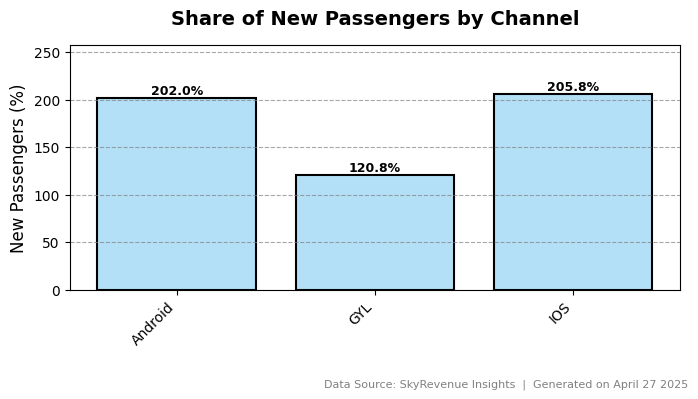

In [10]:
# --------------------------------------------------------------------
# 2. ACQUISITION METRICS
# --------------------------------------------------------------------

acq = (
    df.groupby("ticket_source_name")
      .agg(
          Unique_Passengers=("passenger_id", "nunique"),
          New_Passengers=("is_new_passenger", "sum"),
          Total_Bookings=("ticket_id", "count")
      )
)

acq["New_Pax_%"] = (acq["New_Passengers"] / acq["Unique_Passengers"] * 100).round(1)
acq["Avg_Bookings_per_Pax"] = (
    acq["Total_Bookings"] / acq["Unique_Passengers"]
).round(2)

# ORDER columns
acq = acq[
    ["Unique_Passengers", "New_Passengers", "New_Pax_%",
     "Total_Bookings", "Avg_Bookings_per_Pax"]
]

print(acq)

# --------------------------------------------------------------------
# 3. BAR CHART – Share of New Passengers
# --------------------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(7, 4))

bars = ax1.bar(
    acq.index, acq["New_Pax_%"],
    color="#b3e0f7", edgecolor="black", linewidth=1.5
)

for bar in bars:
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.8,
        f"{bar.get_height():.1f}%",
        ha="center", va="bottom",
        fontsize=9, fontweight="bold"
    )

ax1.set_ylabel("New Passengers (%)", fontsize=12)
ax1.set_title("Share of New Passengers by Channel",
              fontsize=14, fontweight="bold", pad=15)
ax1.grid(True, axis="y", linestyle="--", alpha=0.7, color="grey")
ax1.set_ylim(0, acq["New_Pax_%"].max() * 1.25)
plt.xticks(rotation=45, ha="right")

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.figtext(
    0.99, 0.02,
    "Data Source: SkyRevenue Insights  |  Generated on April 27 2025",
    ha="right", fontsize=8, color="gray"
)
plt.show()


Avg Lead Time by Channel & Discount Flag
Discounted          Discounted  No Discount
ticket_source_name                         
Android                   13.3         11.8
GYL                       10.4          8.2
IOS                       14.3         13.3


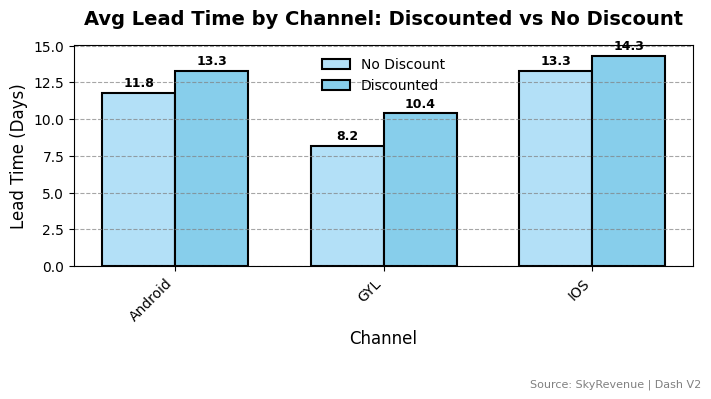

In [12]:
# ─────────── 3. Bar Plot: Avg Lead Time ───────────
lead_time_df = (
    df
    .assign(Discounted=np.where(df["discount_amount"] > 0, "Discounted", "No Discount"))
    .groupby(["ticket_source_name", "Discounted"])["lead_time_days"]
    .mean()
    .reset_index()
    .round(1)
)

# Print table
pivot_lt = lead_time_df.pivot(
    index="ticket_source_name",
    columns="Discounted",
    values="lead_time_days"
)
print("Avg Lead Time by Channel & Discount Flag")
print(pivot_lt.to_string())

# Plot
channels = pivot_lt.index.tolist()
x = np.arange(len(channels))
width = 0.35

fig, ax = plt.subplots(figsize=(7,4))

bars1 = ax.bar(
    x - width/2, pivot_lt["No Discount"],
    width=width,
    color="#b3e0f7", edgecolor="black", linewidth=1.5,
    label="No Discount"
)
bars2 = ax.bar(
    x + width/2, pivot_lt["Discounted"],
    width=width,
    color="#87ceeb", edgecolor="black", linewidth=1.5,
    label="Discounted"
)

for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.2,
            f"{h:.1f}",
            ha="center", va="bottom",
            fontsize=9, fontweight="bold"
        )

ax.set_title("Avg Lead Time by Channel: Discounted vs No Discount",
             fontsize=14, fontweight="bold", pad=15)
ax.set_xlabel("Channel", fontsize=12)
ax.set_ylabel("Lead Time (Days)", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(channels, rotation=45, ha="right")
ax.grid(True, axis="y", linestyle="--", alpha=0.7, color="grey")
ax.legend(frameon=False)

plt.tight_layout(rect=[0,0.08,1,1])
plt.figtext(0.99,0.02,
            "Source: SkyRevenue | Dash V2",
            ha="right", fontsize=8, color="gray")
plt.show()
